In [1]:
from MieSppForce import  green_func, frenel, dipoles, force
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.integrate import quad

In [2]:
c_const = 299792458
eps0_const = 1/(4*np.pi*c_const**2)*1e7
mu0_const = 4*np.pi * 1e-7

def get_directivity(wl, P,M, eps_Au):
    px,py,pz = P
    mx, my,mz = M
    ka = -1j*np.sqrt(1/(eps_Au(wl)+1))
    kspp = np.sqrt(eps_Au(wl)/(eps_Au(wl)+1))
    I = lambda phi:  np.abs((mx/c_const+1j*ka*py)*np.sin(phi) + (my/c_const - 1j*ka*px)*np.cos(phi) - kspp*pz)**2
    Imax = quad(I, 0, 2 * np.pi)[0]
    return  lambda phi: 2 * np.pi * I(phi) / Imax
    


In [3]:
eps_Au = frenel.get_interpolate('Au')
eps_Si = frenel.get_interpolate('Si')

R = 110
#148
dist = 2
#d=60
a_angle = np.pi/4
angle = 35*np.pi/180
point = [0,0,dist+R]
z0 = point[2]
wls=np.linspace(500,900,100)
phase = 0

k0 = lambda wl: 2*np.pi/wl/1e-9
omega = lambda wl: 2*np.pi*c_const/wl/1e-9

In [4]:

STOP=45

F_x01 = np.empty((len(wls), 8))
F_y01 = np.empty_like(F_x01)
F_z01 = np.empty_like(F_x01)

F_x = np.empty((len(wls), 8))
F_y = np.empty_like(F_x)
F_z = np.empty_like(F_x)

P,M = np.empty((len(wls),3), dtype=complex),np.empty((len(wls),3), dtype=complex)




for i in tqdm(range(len(wls))):
    p,m = dipoles.calc_dipoles_v2(wls[i], eps_Au, point, R, eps_Si, angle, amplitude=1, phase=phase, a_angle=a_angle, stop=STOP)
    p,m = p[:,0],m[:,0]
    P[i,:],M[i,:]=p,m
    
    f =  force.F(wls[i], eps_Au, point, R, eps_Si, angle,amplitude=1,phase=phase,a_angle=a_angle, stop=STOP, full_output=True, stop_dipoles=45)
    F_x[i,:] = f[0]
    F_y[i,:] = f[1]
    F_z[i,:] = f[2]
    
    f =  force.F(wls[i], eps_Au, point, R, eps_Si, angle,amplitude=1,phase=phase,a_angle=a_angle, stop=1, full_output=True, stop_dipoles=45)
    F_x01[i,:] = f[0]
    F_y01[i,:] = f[1]
    F_z01[i,:] = f[2]
    

    

   
  
        

 12%|█▏        | 12/100 [00:28<03:29,  2.38s/it]c:\Users\borod\Desktop\SPP_ANALYTICAL\SPP_ANALYTICAL\.venv\Lib\site-packages\scipy\integrate\_quadpack_py.py:444: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  im_retval = quad(imfunc, a, b, args, full_output, epsabs,
 42%|████▏     | 42/100 [01:44<02:35,  2.68s/it]c:\Users\borod\Desktop\SPP_ANALYTICAL\SPP_ANALYTICAL\.venv\Lib\site-packages\scipy\integrate\_quadpack_py.py:441: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  re_retval = quad(refunc, a, b, args, full_output, epsabs,
100%|██████████| 100/100 [04:28<00:00,  2.69s/it]


In [24]:
Fsppx = F_x - F_x01
Fsppy = F_y - F_y01
Fsppz = F_z - F_z01

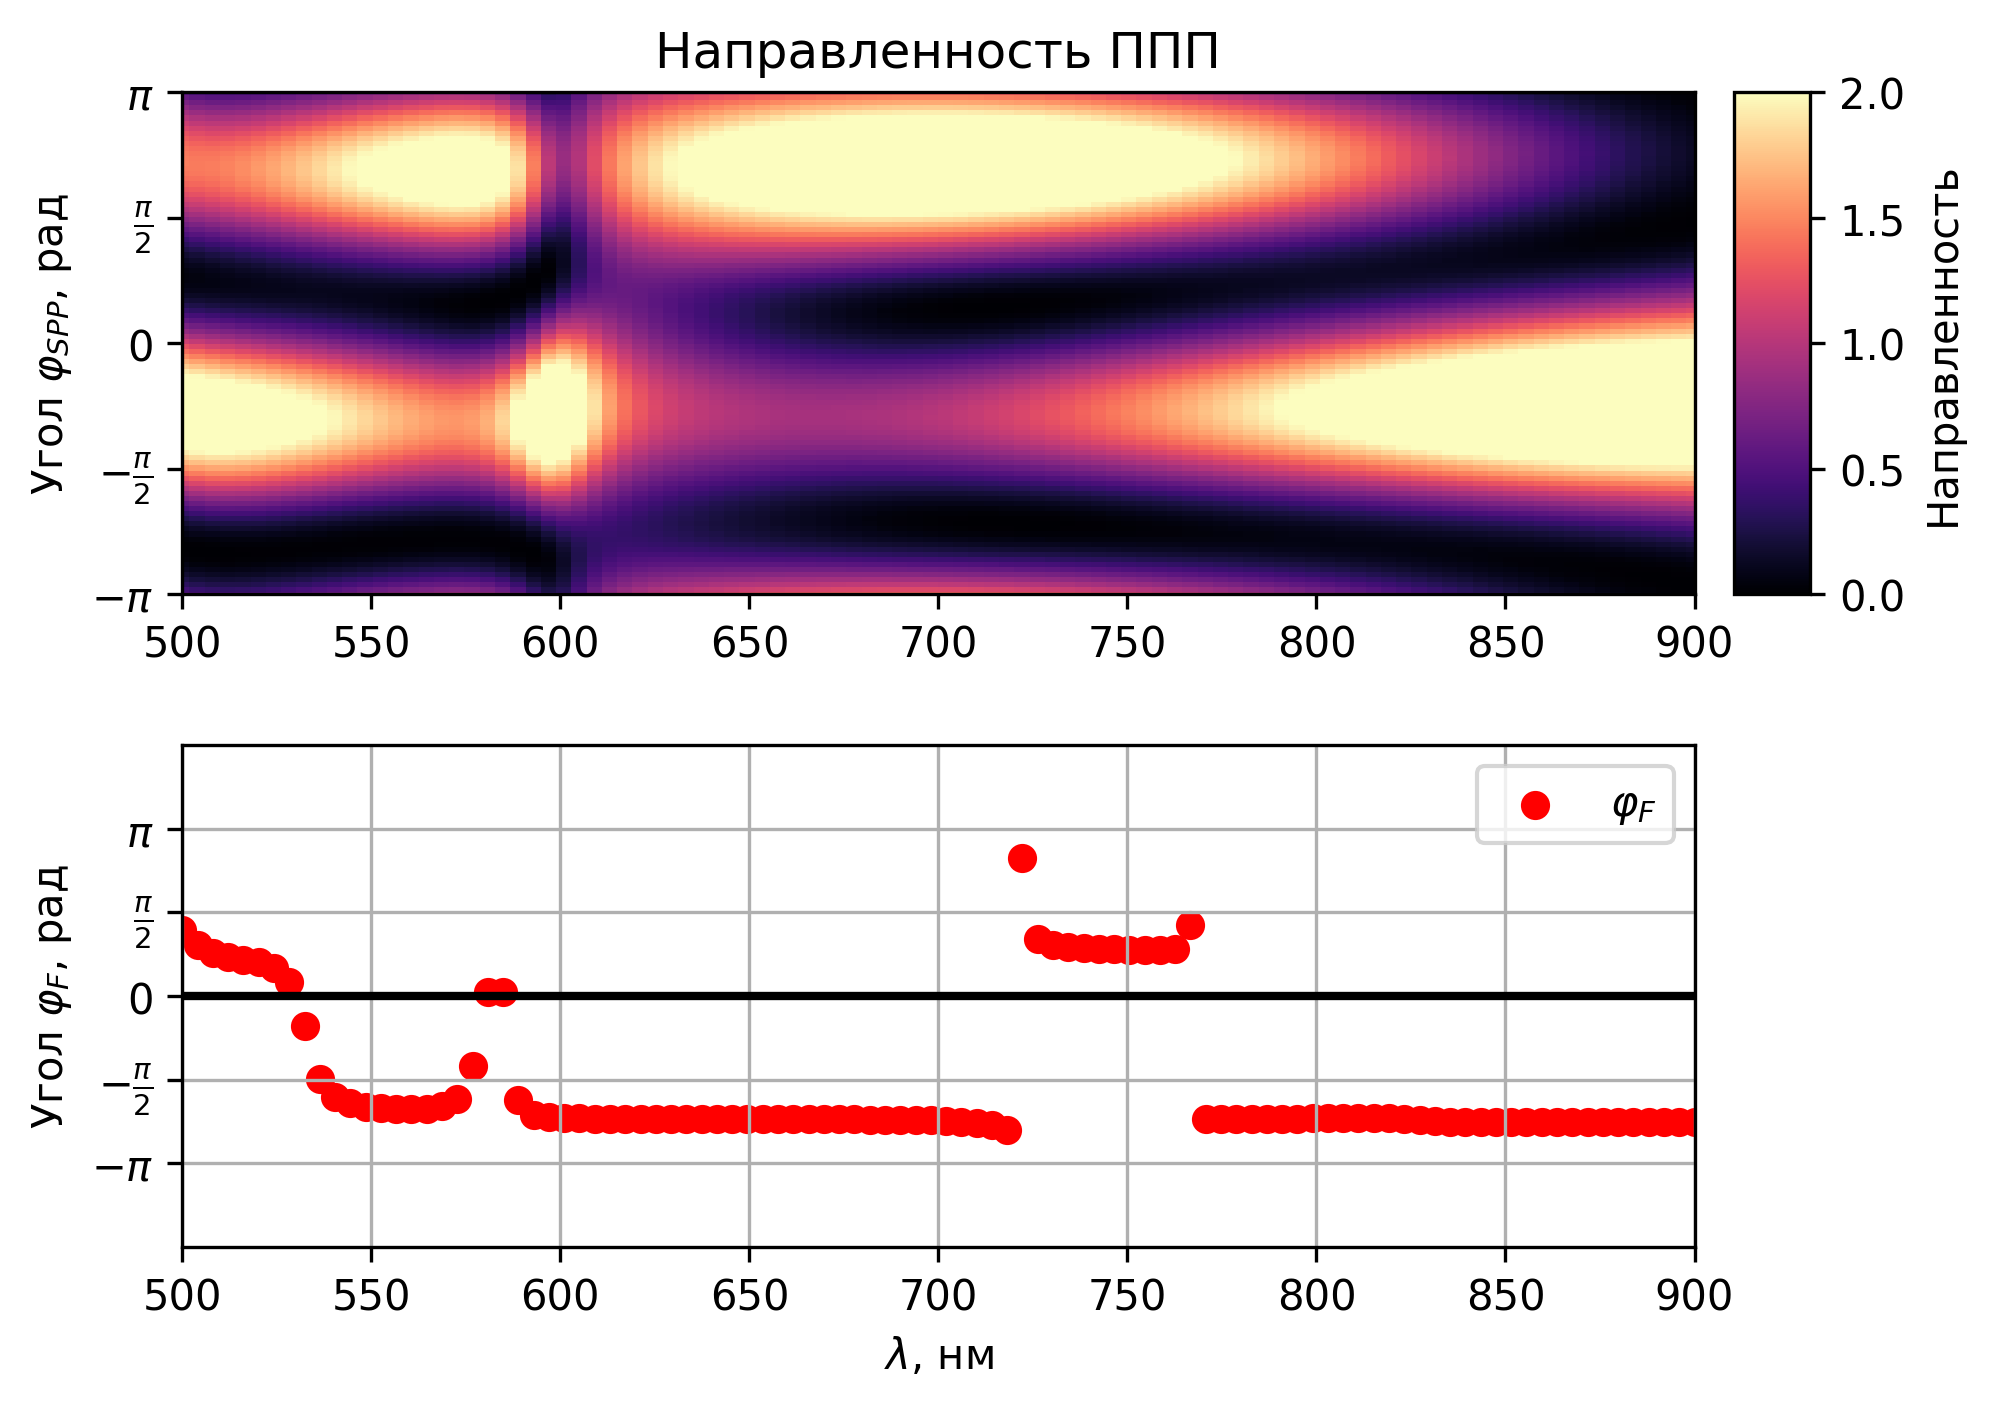

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

PHI = np.linspace(-np.pi, np.pi, 100)

directivity = np.empty((len(PHI), len(wls)))
for wl_idx, wl in enumerate(wls):
    for angle_idx in range(len(PHI)):
        D = get_directivity(wl, P[wl_idx,:], M[wl_idx,:], eps_Au)
        directivity[angle_idx, wl_idx] = D(PHI[angle_idx])



# === Создание фигуры и макета ===
fig = plt.figure(figsize=(7, 5), dpi=300)
gs = gridspec.GridSpec(2, 2, width_ratios=[20, 1], height_ratios=[1, 1], hspace=0.3, wspace=0.05)

# === Верхний график (тепловая карта) ===
ax_top = fig.add_subplot(gs[0, 0])
directivity_map = ax_top.pcolor(wls, PHI, directivity, cmap='magma', vmax=2, vmin=0)

# Настройка оси Y: метки углов в виде кратных π
# y_ticks = [0, np.pi/2, np.pi, np.pi*3/2, 2*np.pi]
# y_ticklabels = [r'$0$', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$']
y_ticks = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]
y_ticklabels = [r'$-\pi$', r'$-\frac{\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$', r'$\pi$']
ax_top.set_yticks(y_ticks)
ax_top.set_yticklabels(y_ticklabels)

ax_top.set_ylim(-np.pi, np.pi)
ax_top.set_ylabel(r'Угол $\varphi_{SPP}$, рад')
ax_top.set_title('Направленность ППП')

# === Colorbar ===
cax = fig.add_subplot(gs[0, 1])
fig.colorbar(directivity_map, cax=cax, label='Направленность')

# === Нижний график (углы силы) ===
ax_bottom = fig.add_subplot(gs[1, 0], sharex=ax_top)

angles_no_sc= np.arctan2(Fsppy[:,0], Fsppx[:,0])

#angles_no_sc= np.unwrap(angles_no_sc)

# Отрисовка угла


# Границы и метки оси Y
y_ticks = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]
y_ticklabels = [r'$-\pi$', r'$-\frac{\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$', r'$\pi$']
ax_bottom.set_yticks(y_ticks)
ax_bottom.set_yticklabels(y_ticklabels)
ax_bottom.axhline(0, color='black', linestyle='-', linewidth=2)
# closest_to_zero_idx = np.argmin(np.abs(angles_no_sc_from_R))
# approx_zero_crossing_x = Rs[closest_to_zero_idx]
# ax_bottom.axvline(approx_zero_crossing_x, color='black', linestyle='--', linewidth=2)
ax_bottom.scatter(wls, angles_no_sc, label=r'$\varphi_F$', color='r', linewidth=1)
ax_bottom.set_ylim(-9*np.pi/6, 9*np.pi/6)
ax_bottom.set_xlim(wls[0], wls[-1])
ax_bottom.set_xlabel('$\\lambda$, нм')
ax_bottom.set_ylabel(r'Угол $\varphi_F$, рад')
ax_bottom.grid(True)
ax_bottom.legend()
#plt.savefig(f'spp_vs_f_nosc_from_wl_z0_{point[2]}_R_{R}_phase_{phase}.png', dpi=300)



In [38]:
phi_D_from_wl = np.empty(len(wls))
for i in range(len(wls)):
    j = np.argmax(directivity[:,i])
    phi_D_from_wl[i] = PHI[j]

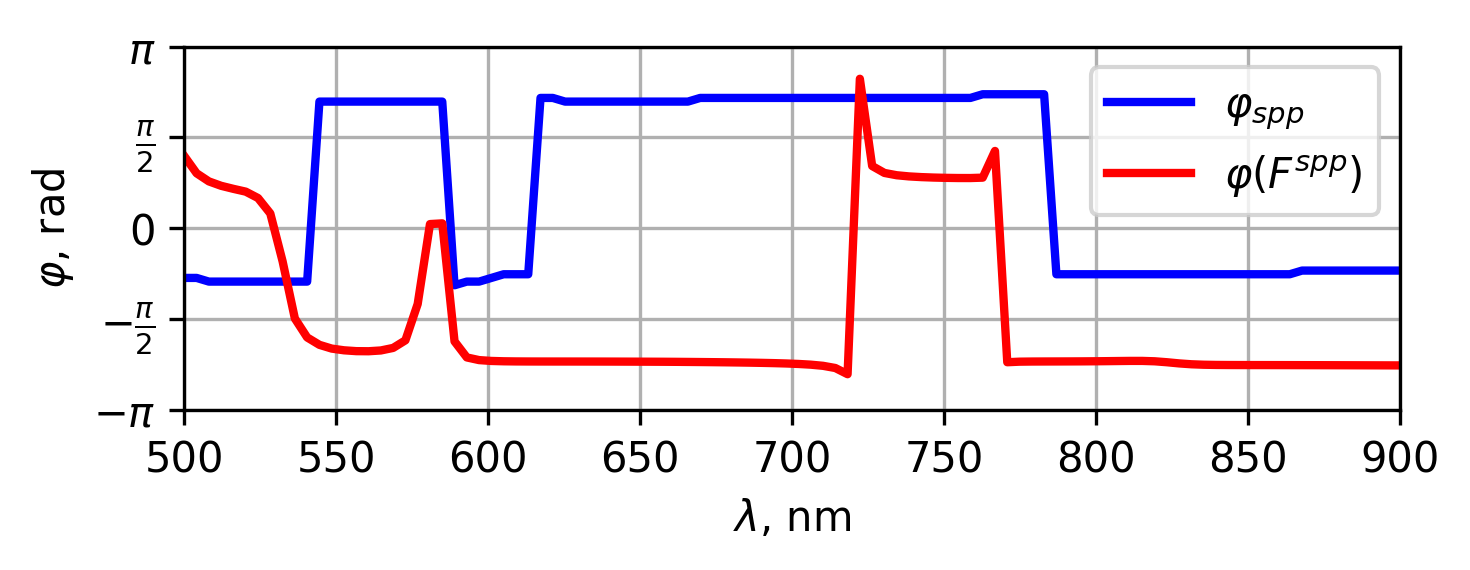

In [41]:
plt.figure(figsize=(5,2), dpi=300)
plt.plot(wls, phi_D_from_wl, label=r'$\varphi_{spp}$', c='blue', lw=2)

#plt.plot(Rs, angles_no_sc_from_R, label=r'$\varphi (F^{no\;sc})$', lw=2, c='r')
plt.plot(wls, np.arctan2(Fsppy[:,0], Fsppx[:,0]), label=r'$\varphi (F^{spp})$', lw=2, c='r')

plt.grid()
plt.legend()
y_ticks = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]
y_ticklabels = [r'$-\pi$', r'$-\frac{\pi}{2}$',r'$0$', r'$\frac{\pi}{2}$', r'$\pi$']
plt.yticks(y_ticks,y_ticklabels)
plt.xlim(wls[0],wls[-1])
plt.ylabel('$\\varphi$, rad')
plt.xlabel('$\\lambda$, nm')
plt.tight_layout()
plt.savefig(f'spp_vs_f_spp_from_R_z0_{dist}_angle_plot.png', dpi=300)
plt.show()

In [30]:
fmax_wls = 0
for i in range(len(wls)):
    f0 = force.F(wls[i], 1, [0,0,0], R, eps_Si, 0,amplitude=1,phase=0,a_angle=0, stop=STOP, full_output=False)[2]
    f0 = np.abs(f0)
    if f0 > fmax_wls:
        fmax_wls = f0

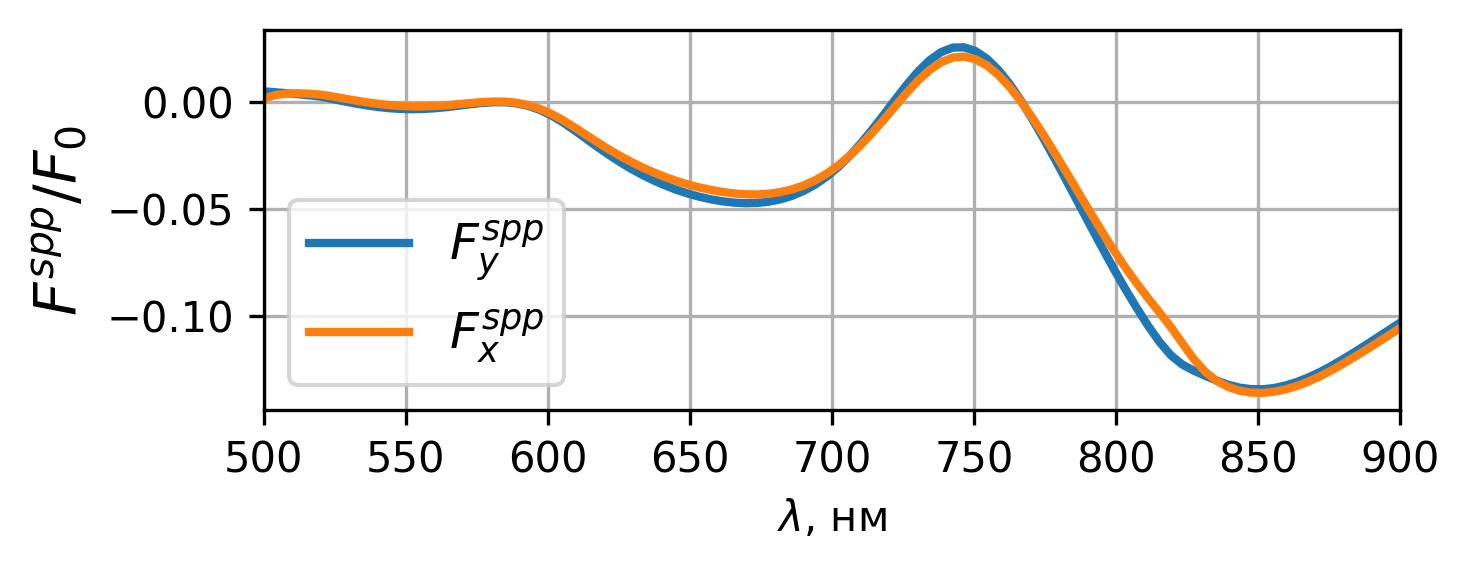

In [37]:
fig, ax1 = plt.subplots(1, 1, figsize=(5, 2), sharex=True, dpi=300)


ax1.plot(wls, Fsppy[:,0]/fmax_wls, label='$F_y^{spp}$', linewidth=2, color='#1f77b4')
ax1.plot(wls, Fsppx[:,0]/fmax_wls, label='$F_x^{spp}$', linewidth=2, color='#ff7f0e')

ax1.set_ylabel('$F^{spp}/F_0$', fontsize=14)
ax1.grid(True)
ax1.legend(fontsize=12)
ax1.set_xlabel('$\\lambda$, нм')

plt.xlim(wls[0], wls[-1])

plt.tight_layout()
plt.savefig(f'f_spp_from_wl_z0_{point[2]}.pdf', dpi=300)
plt.show()


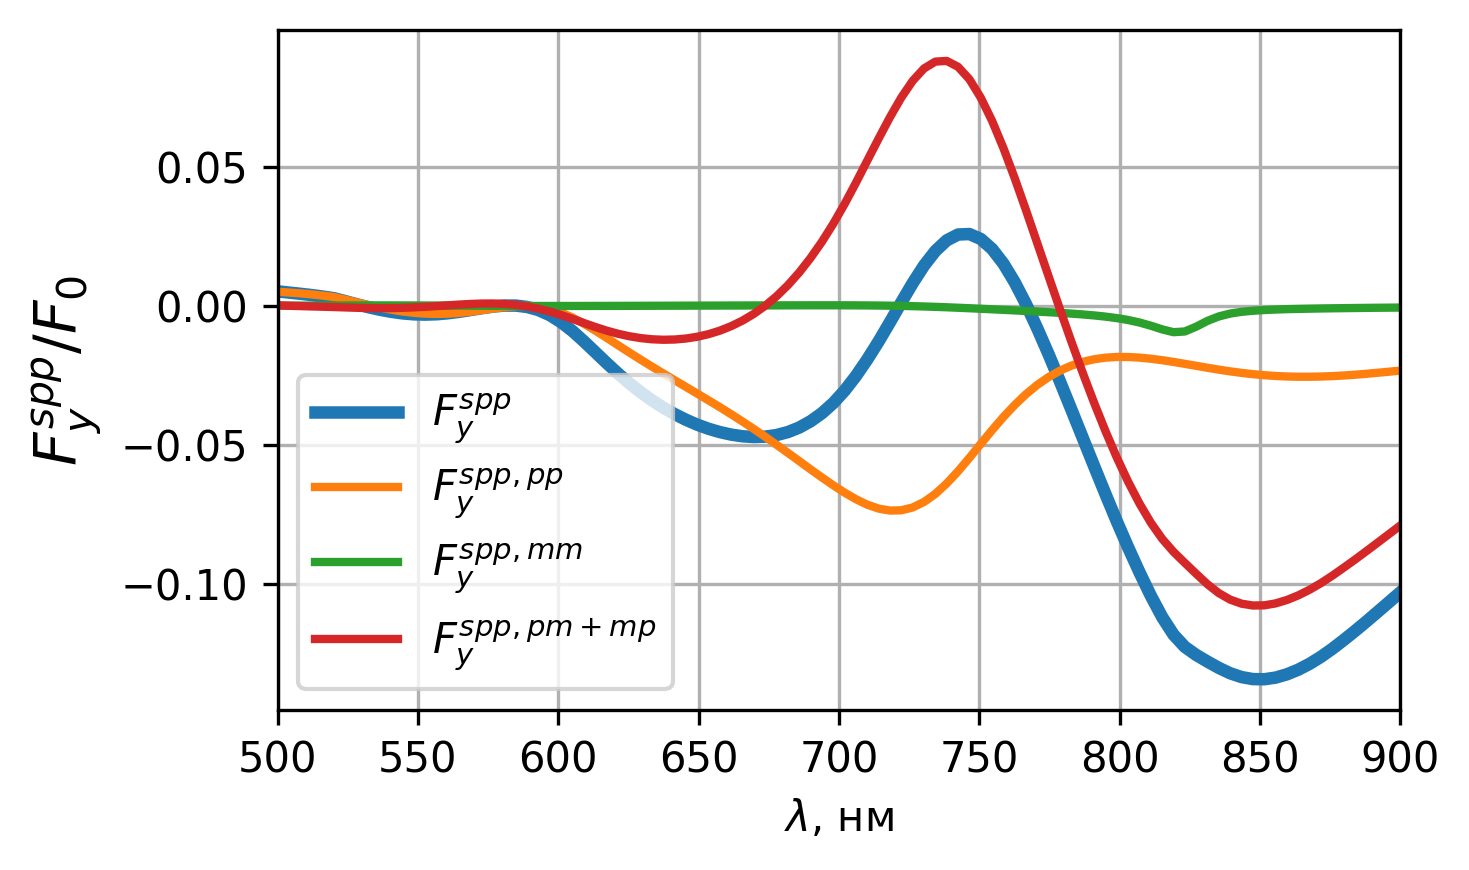

In [35]:
fig, ax1 = plt.subplots(1, 1, figsize=(5, 3), sharex=True, dpi=300)


ax1.plot(wls, Fsppy[:,0]/fmax_wls, label='$F_y^{spp}$', linewidth=3)
ax1.plot(wls, Fsppy[:,2]/fmax_wls, label='$F_y^{spp,pp}$', linewidth=2)
ax1.plot(wls, Fsppy[:,5]/fmax_wls, label='$F_y^{spp,mm}$', linewidth=2)
ax1.plot(wls, (Fsppy[:,6]+Fsppy[:,3])/fmax_wls, label='$F_y^{spp,pm+mp}$', linewidth=2)
#ax1.plot(wls, F_y[:,7]/fmax_wls, label='$F_y^{\\times}$', linewidth=2)

ax1.set_ylabel('$F_y^{spp}/F_0$', fontsize=14)
ax1.grid(True)
ax1.legend()
ax1.set_xlabel('$\\lambda$, нм')

plt.xlim(wls[0], wls[-1])

plt.tight_layout()
plt.savefig(f'f__spp_y_from_wl_z0_{point[2]}.png', dpi=300)
plt.show()




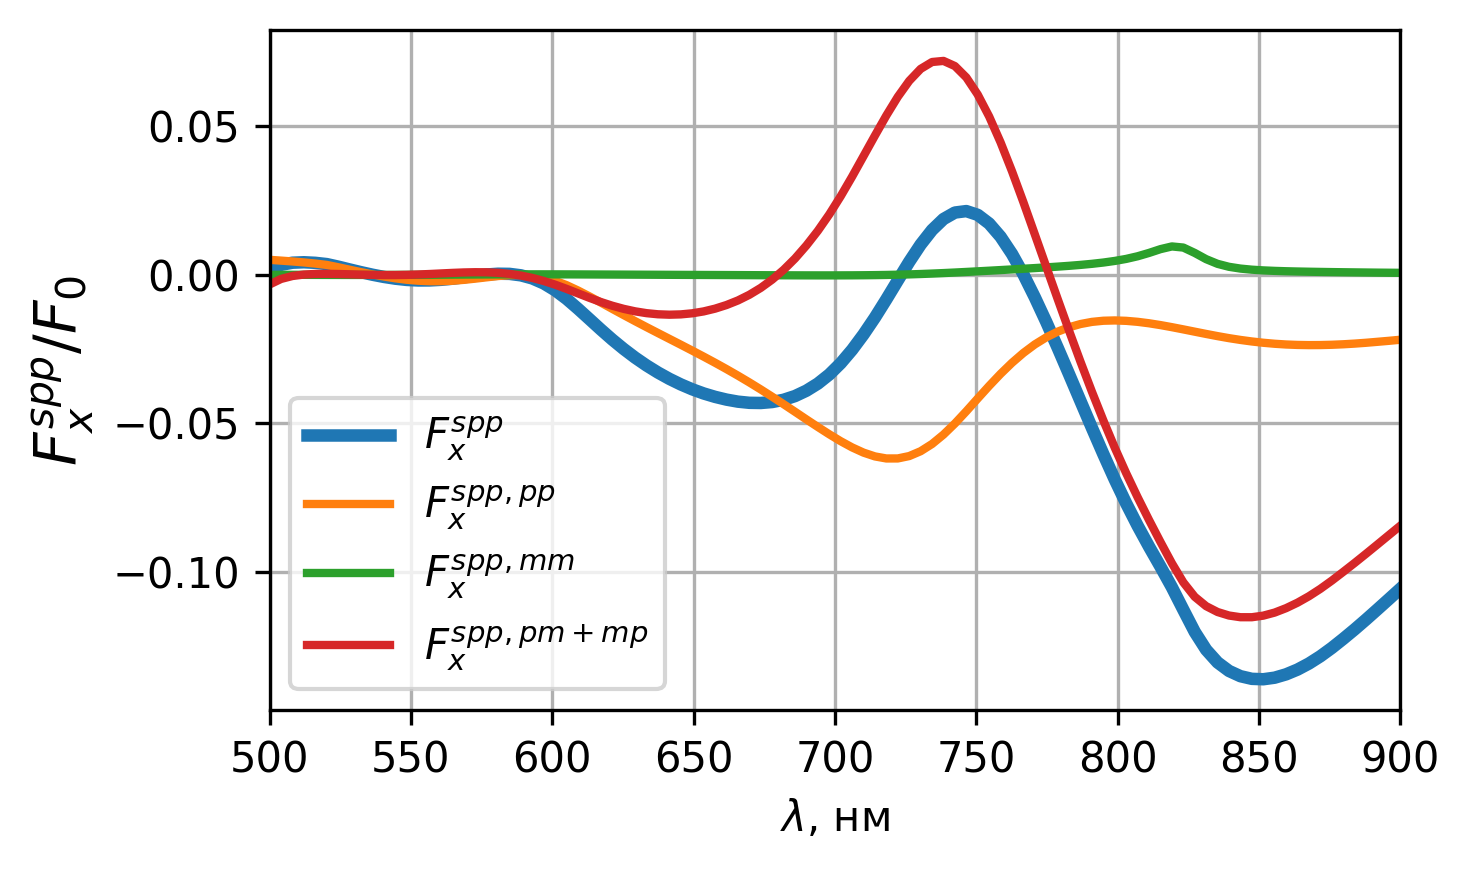

In [36]:
fig, ax1 = plt.subplots(1, 1, figsize=(5, 3), sharex=True, dpi=300)


ax1.plot(wls, Fsppx[:,0]/fmax_wls, label='$F_x^{spp}$', linewidth=3)
ax1.plot(wls, Fsppx[:,2]/fmax_wls, label='$F_x^{spp,pp}$', linewidth=2)
ax1.plot(wls, Fsppx[:,5]/fmax_wls, label='$F_x^{spp,mm}$', linewidth=2)
ax1.plot(wls, (Fsppx[:,6]+Fsppx[:,3])/fmax_wls, label='$F_x^{spp,pm+mp}$', linewidth=2)
#ax1.plot(wls, F_y[:,7]/fmax_wls, label='$F_y^{\\times}$', linewidth=2)

ax1.set_ylabel('$F_x^{spp}/F_0$', fontsize=14)
ax1.grid(True)
ax1.legend()
ax1.set_xlabel('$\\lambda$, нм')

plt.xlim(wls[0], wls[-1])

plt.tight_layout()
plt.savefig(f'f__spp_x_from_wl_z0_{point[2]}.png', dpi=300)
plt.show()

In [42]:

STOP = 45
ANGLE = 35 * np.pi / 180
wl = 700

phase_values = np.linspace(-np.pi, np.pi, 50)
a_angle = np.linspace(0, np.pi/2, 50)
angles = np.linspace(0, 2 * np.pi, 100)

def compute_for_params(angle_index, pha, a_i):
    p, m = dipoles.calc_dipoles_v2(wl, eps_Au, point, R, eps_Si, ANGLE,
                                   amplitude=1, phase=pha, a_angle=a_i, stop=STOP)
    p, m = p[:, 0], m[:, 0]
    D = get_directivity(wl, p, m, eps_Au)
    D_angle = D(angles[angle_index])


    return angle_index, pha, a_i, D_angle, p, m


results = []


for angle_index in tqdm(range(len(angles))):
    for pha in phase_values:
        for a_i in a_angle:
            result = compute_for_params(angle_index, pha, a_i)
            results.append(result)

best_D = np.zeros(len(angles))
best_params = np.empty((len(angles), 2))
dipoles_p = np.empty((len(angles), 3), dtype=np.complex128)
dipoles_m = np.empty((len(angles), 3), dtype=np.complex128)

for i, pha, a_i, D, p, m in results:
    if D > best_D[i]:
        best_D[i] = D
        best_params[i] = (pha, a_i)
        dipoles_p[i] = p
        dipoles_m[i] = m



  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\borod\Desktop\SPP_ANALYTICAL\SPP_ANALYTICAL\.venv\Lib\site-packages\scipy\integrate\_quadpack_py.py:441: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  re_retval = quad(refunc, a, b, args, full_output, epsabs,
100%|██████████| 100/100 [02:26<00:00,  1.46s/it]


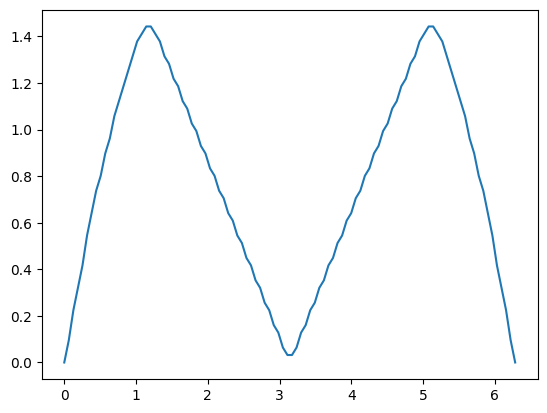

In [43]:
plt.plot(angles, np.unwrap(best_params[:,1]))

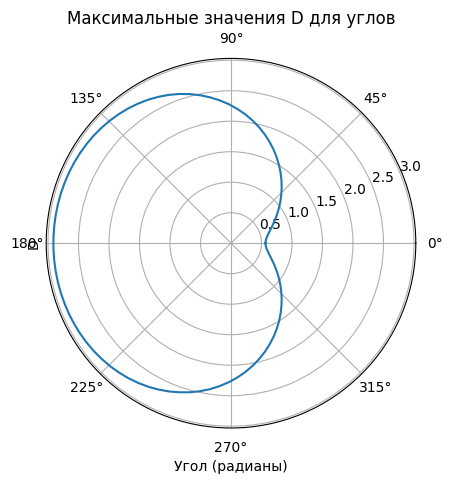

In [44]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(angles, best_D)
ax.grid(True)
plt.xlabel("Угол (радианы)")
plt.ylabel("D")
ax.set_title("Максимальные значения D для углов")
plt.show()

In [47]:
PHI = np.linspace(0, 2*np.pi, 100)

F_x01_opt = np.empty((len(wls), 8))
F_y01_opt  = np.empty_like(F_x01)
F_z01_opt  = np.empty_like(F_x01)

F_x_opt  = np.empty((len(wls), 8))
F_y_opt  = np.empty_like(F_x)
F_z_opt  = np.empty_like(F_x)


directivity_opt = np.empty((len(PHI), len(best_params)))
for par_id, param in enumerate(best_params):
    for angle_idx in range(len(PHI)):
        D = get_directivity(wl, dipoles_p[par_id], dipoles_m[par_id], eps_Au)
        directivity_opt[angle_idx, par_id] = D(PHI[angle_idx])
        
        

for i in tqdm(range(len(best_params))):
    f =  force.F(wl, eps_Au, point, R, eps_Si, angle,amplitude=1,phase=best_params[i,0],a_angle=best_params[i,1], stop=STOP, full_output=True, stop_dipoles=45)
    F_x_opt[i,:] = f[0]
    F_y_opt[i,:] = f[1]
    F_z_opt[i,:] = f[2]
    
    f =  force.F(wl, eps_Au, point, R, eps_Si, angle,amplitude=1,phase=best_params[i,0],a_angle=best_params[i,1],stop=1, full_output=True, stop_dipoles=45)
    F_x01_opt[i,:] = f[0]
    F_y01_opt[i,:] = f[1]
    F_z01_opt[i,:] = f[2]
    

100%|██████████| 100/100 [00:01<00:00, 55.87it/s]


In [48]:
Fsppx_opt = F_x_opt - F_x01_opt
Fsppy_opt = F_y_opt - F_y01_opt
Fsppz_opt = F_z_opt - F_z01_opt

In [49]:
phiii = np.empty(len(best_params))
for i in range(len(best_params)):
    j = np.argmax(directivity_opt[:,i])
    phiii[i] = PHI[j]


(0.0, 100.0)

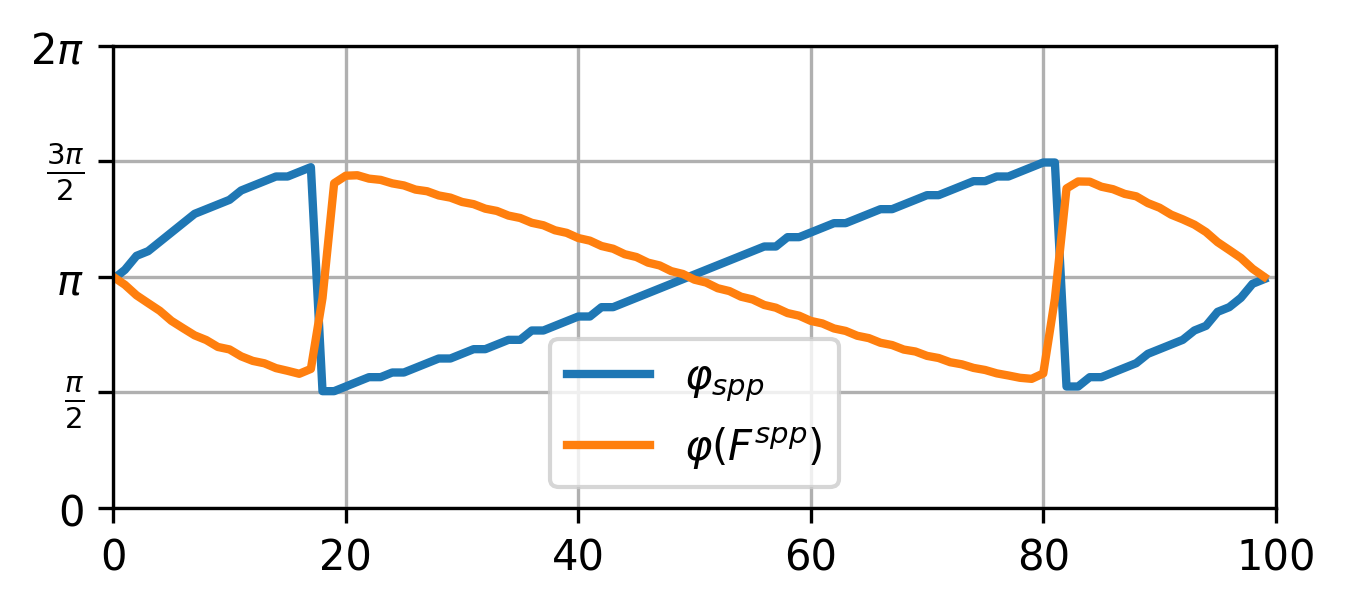

In [59]:
plt.figure(figsize=(5,2), dpi=300)
plt.plot(range(len(best_params)), phiii, label=r'$\varphi_{spp}$', lw=2)
plt.plot(range(len(best_params)), np.unwrap(np.arctan2(Fsppy_opt[:,2], Fsppx_opt[:,2])), label=r'$\varphi (F^{spp})$', lw=2)
plt.grid()
plt.legend()
y_ticks = [0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi]
y_ticklabels = [ r'$0$', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$']
plt.yticks(y_ticks,y_ticklabels)

plt.xlim(0,len(best_params))

(0.0, 100.0)

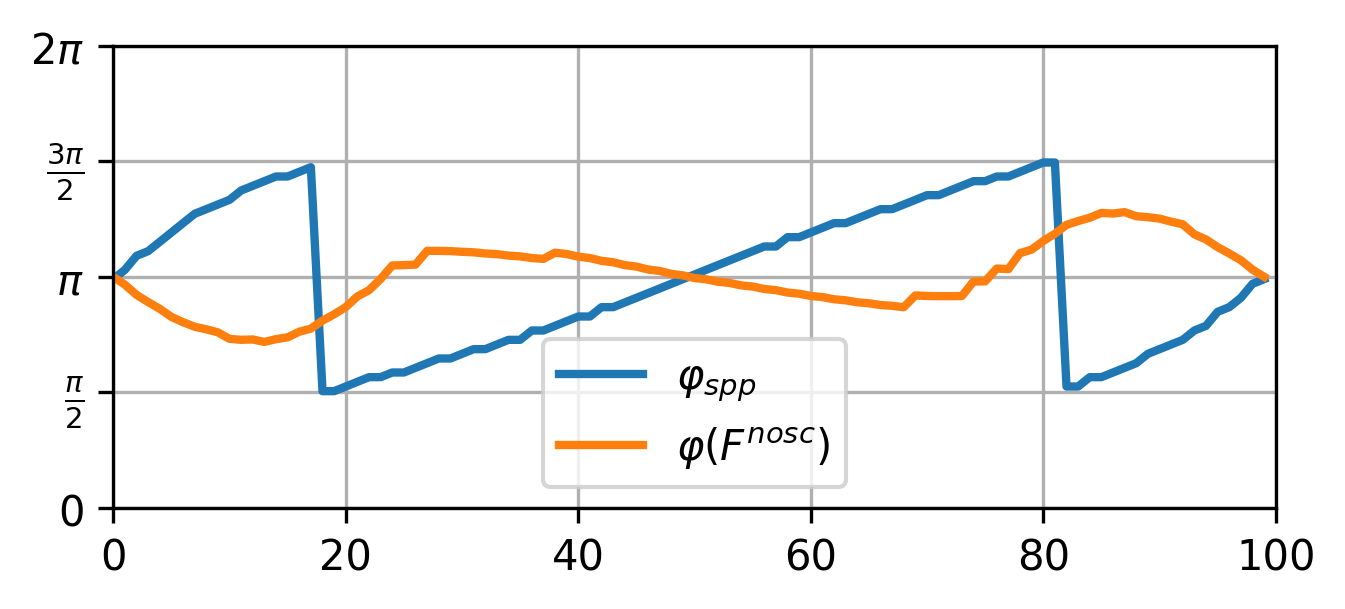

In [53]:
plt.figure(figsize=(5,2), dpi=300)
plt.plot(range(len(best_params)), phiii, label=r'$\varphi_{spp}$', lw=2)
plt.plot(range(len(best_params)), np.unwrap(np.arctan2(F_y_opt[:,0], F_x_opt[:,0]-F_x_opt[:,1]-F_x_opt[:,4])), label=r'$\varphi (F^{no sc})$', lw=2)
plt.grid()
plt.legend()
y_ticks = [0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi]
y_ticklabels = [ r'$0$', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$']
plt.yticks(y_ticks,y_ticklabels)

plt.xlim(0,len(best_params))